In [1]:
### This note book is for selecting the essential genes in the screen
import pandas as pd
import re
from os import listdir
from os.path import join
import pickle

In [2]:
def sel_by_quantl(df, direction, quantile = 0.75):
    if direction == 'higher':
        sel_idx = df[df>df.quantile(quantile)].dropna().index
    elif direction == 'lower':
        sel_idx = df[df<df.quantile(quantile)].dropna().index
        
    sel_gene = set([x.split(' ')[0] for x in sel_idx])
    return(sel_gene)

In [3]:
# # How did I process the K562 gene effect score
# df_effect = pd.read_csv('../data/22Q2_gene_effect/CRISPR_gene_effect.csv', index_col = 0)
# # So K562 = ACH-000551, get K562 specific gene scores
# df_effect_k562 = df_effect.loc['ACH-000551',:]
# df_effect_k562.to_csv('./gene_effect_k562.csv')

In [4]:
path= '../../data/22Q2_gene_effect/'

***We take the intersection of genes that:***
1. Are essential (Union/intersection? of K562 essential and common essential)
2. Synonymous mutations are depleted
3. Express in K562

In [5]:
### Common essential genes###
df_comm_ess = pd.read_csv(join(path, 'common_essentials.csv'))
comm_ess_genes = df_comm_ess['gene'].apply(lambda x: x.split('(')[0].split(' ')[0]).unique()
df_non_ess = pd.read_csv(join(path,'nonessentials.csv'))
noness_genes = df_non_ess['gene'].apply(lambda x: x.split('(')[0].split(' ')[0]).unique()

array([[<AxesSubplot:title={'center':'ACH-000551'}>]], dtype=object)

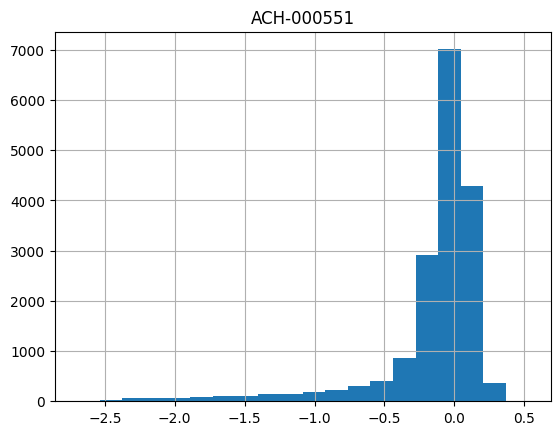

In [6]:
### Check how much of the common essential overlap with K562 essential genes
df_effect_k562 = pd.read_csv(join(path,'gene_effect_k562.csv'), index_col = 0)
idx_genes = [i.split('(')[0].split(' ')[0] for i in df_effect_k562.index]
df_effect_k562['genes'] = idx_genes
df_effect_k562 = df_effect_k562.set_index('genes')
# df_effect_k562.describe() # std is quite large, almost 50% of the genes are somewhat essential
df_effect_k562.hist(bins = 20) # There's a step around -0.5, that take that

In [7]:
df_effect_k562.quantile(0.01)

ACH-000551   -2.039344
Name: 0.01, dtype: float64

In [8]:
# Select and compare between common essential and K562 essential
ess_k562 = df_effect_k562[df_effect_k562 < df_effect_k562.quantile(0.01)].dropna().index
# ess_k562 = df_effect_k562[df_effect_k562 < df_effect_k562.quantile(0.5)].dropna().index
print(f'There are {len(ess_k562)} essential K562 genes and {len(comm_ess_genes)} common essential genes')

There are 174 essential K562 genes and 1247 common essential genes


In [9]:
ess_gene = ess_k562.intersection(comm_ess_genes)
print(f'{len(ess_k562.intersection(comm_ess_genes))} of common essential genes in K562 essential genes')

128 of common essential genes in K562 essential genes


***Sort the intersection of genes and get top 100 list***

In [9]:
# top100_ess = list(df_effect_k562.loc[ess_gene,:].sort_values('ACH-000551').head(100).index)

In [10]:
# with open('../data/output/K562_comm_ess_100.txt','w') as f:
#     for genes in top100_ess:
#         f.write(genes+'\n')
        
# more_ess = [i for i in ess_gene if i not in top100_ess]
# with open('../data/output/K562_comm_ess_more.txt','w') as f:
#     for genes in more_ess:
#         f.write(genes+'\n')
        
with open('../../data/output/K562_comm_ess.txt','w') as f:
    for genes in ess_gene:
        f.write(genes+'\n')

***Get neutral gene list(Intersection between common non essential and K562 nonessentials)***

In [12]:
df_non_ess = pd.read_csv(join(path,'nonessentials.csv'))
noness_genes = df_non_ess['gene'].apply(lambda x: x.split('(')[0].split(' ')[0]).unique()

In [13]:
neutral_list = list(df_effect_k562[(df_effect_k562['ACH-000551']>-0.01)&\
                                   (df_effect_k562['ACH-000551']<0.01)].index)

In [14]:
neutral_list = (set(noness_genes).intersection(set(neutral_list)))

In [15]:
print(f'{len(neutral_list)} of non essential genes in K562 essential genes')

41 of non essential genes in K562 essential genes


In [17]:
with open('../../data/output/K562_neutral.txt','w') as f:
    for genes in neutral_list:
        f.write(genes+'\n')

***Filter out transcripts/genes that are not expressed***

In [9]:
# df_transcript_exp = pd.read_csv('../data/22Q2_gene_effect/K562_tpm.csv', index_col = 0,header = None)
# df_transcript_exp_header = pd.read_csv('../data/22Q2_gene_effect/K562_tpm_header.csv', index_col = 0)
# df_transcript_exp.columns = df_transcript_exp_header.columns
# pickle.dump(df_transcript_exp,open(join(path, 'K562_tpm.pkl'),'wb'))

df_transcript_exp = pickle.load(open(join(path,'K562_tpm.pkl'),'rb'))

In [10]:
# We filter out transcripts in K562 that are expressed very low, This is TPM data downloaded from 22Q2 
# Organize the dataframe..
df_transcript_exp = df_transcript_exp.transpose().reset_index()
splitted_transcript_cols = df_transcript_exp['index'].str.split('\(|\)', expand = True)
df_transcript_exp = df_transcript_exp.drop(columns ='index')
df_transcript_exp['gene'] = splitted_transcript_cols[0]
df_transcript_exp['ensembl_transcript'] = splitted_transcript_cols[1]
df_transcript_exp = df_transcript_exp.dropna()

In [11]:
# All measured genes in K562
gene_lists = [x.strip(' ') for x in df_transcript_exp.gene.unique()]

# half of the transcripts TPM = 0, let's first filter them out
df_trsp_exp_sel = df_transcript_exp[df_transcript_exp['ACH-000551']>0]

exp_genes = [x.strip(' ') for x in df_trsp_exp_sel.gene.unique()]
exp_transcripts = [x.strip(' ') for x in df_trsp_exp_sel.ensembl_transcript.unique()]

In [24]:
# MANE file downloaded from: https://ftp.ncbi.nlm.nih.gov/refseq/MANE/MANE_human/current/
# This part map the ensembl transcriptID to refseq ID
df_mane = pd.read_csv('../../data/MANE/MANE.GRCh38.v1.0.refseq_genomic.gtf', sep = '\t')
df_mane_ref_embs = df_mane[df_mane['gene'] == 'transcript'].iloc[:,8].str.split(';', expand=True)
df_mane_ref_embs = pd.concat([df_mane_ref_embs,df_mane.iloc[df_mane_ref_embs.index,[3,4]]], axis = 1)
mane_trsp_id = df_mane_ref_embs.iloc[:,2].apply(lambda x: x.split('Ensembl:')[-1].split('"')[0].split('.')[0])
mane_refseq_id = df_mane_ref_embs.iloc[:,1].apply(lambda x: x.split('transcript_id "')[-1].split('"')[0].split('.')[0])
if len(mane_trsp_id) == len(mane_refseq_id):
    df_refseq_emb = pd.DataFrame({'Ensembl':mane_trsp_id,
                                 'refSeq':mane_refseq_id,
                                 'Gene_name':df_mane_ref_embs[0],
                                'Start':df_mane_ref_embs.iloc[:,-2],
                                'End':df_mane_ref_embs.iloc[:,-1]})

In [39]:
# df_refseq_emb.to_csv('MANE_esm_refseq_gene.csv')

In [26]:
# Save the list of expressed transcripts; use as filters later
exp_trsp_refseq = list(df_refseq_emb[df_refseq_emb['Ensembl'].isin(exp_transcripts)].refSeq)
pickle.dump(exp_trsp_refseq, open(join(path,'expressed_transcripts.pkl'),'wb'))

### Identify the negatively selected genes in gnomad

In [3]:
gnomad = pd.read_csv('../../data/gnomad.v4.1.constraint_metrics.tsv', sep = '\t')

In [17]:
sub_df = gnomad[gnomad['gene'].isin(ess_gene)]
sub_df = sub_df[(sub_df['mane_select'] == True) & (sub_df['canonical'] == True)]
sub_df = sub_df[sub_df['transcript_type'] == 'protein_coding']

In [21]:
sub_df[sub_df['mis.z_score']>2]/len(sub_df)
sub_df[sub_df['lof.pLI']>0.9]/len(sub_df)

124

In [24]:
for i in ess_gene:
    if i not in sub_df['gene'].unique():
        print(i)

EIF3I
HCFC1
RPS4X
UBA1
